##### Part 1-2 (Repeated)

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tensorflow import keras
from scipy.ndimage import rotate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from keras.utils import to_categorical

In [2]:
def Read_Images(folder_paths):
    images = []
    labels = []
    for i,folder_path in enumerate(folder_paths):
        for filename in os.listdir(folder_path):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                img = np.array(Image.open(os.path.join(folder_path, filename)))
                images.append(img)
                labels.append(i)
    return [np.array(images), np.array(labels)]

In [3]:
folder_names = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

train_path = 'Dataset_Part1/Train/'
tune_path = 'Dataset_Part1/Tune/'

train_folder_paths = []
tune_folder_paths = []

for folder_name in folder_names:
    train_folder_paths.append(os.path.join(train_path, folder_name))

for folder_name in folder_names:
    tune_folder_paths.append(os.path.join(tune_path, folder_name))

x, y = Read_Images(train_folder_paths)
x_tune, y_tune = Read_Images(tune_folder_paths)

num_classes = 8

x = x/255
x_tune = x_tune/255

print(x.shape)
print(y.shape)
print(x_tune.shape)
print(y_tune.shape)


(8000, 128, 128, 3)
(8000,)
(1600, 128, 128, 3)
(1600,)


In [4]:
T = x.shape[0]
batch_size = 40

data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

augmented_data = data_generator.flow(x, y, batch_size=batch_size)

num_batches = int(0.2*T/batch_size)
x_mixed = [x]
y_mixed = [y]

for _ in range(num_batches):
    x_batch_augmented, y_batch_augmented = augmented_data.next()
    x_mixed.append(x_batch_augmented)
    y_mixed.append(y_batch_augmented)

x_mixed = np.concatenate(x_mixed, axis=0)
y_mixed = np.concatenate(y_mixed, axis=0)

x_train, x_test, y_train, y_test = train_test_split(x_mixed, y_mixed, test_size=0.2, random_state=42)

print(x_train.shape)
print(y_train.shape)

(7680, 128, 128, 3)
(7680,)


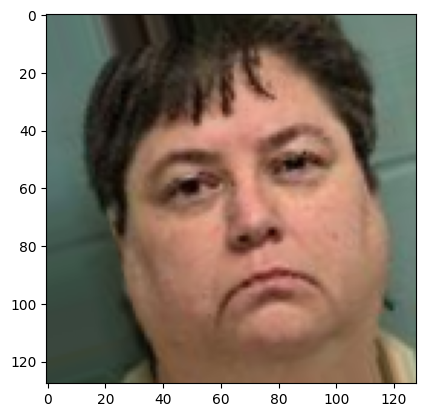

In [5]:
plt.imshow(x_batch_augmented[5,:,:,:])
plt.show()

### Question 2

##### Part 2-1

In [6]:
VGGNet = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", input_shape=(128,128,3)),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.GaussianDropout(0.2, seed=10),

    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.GaussianDropout(0.2, seed=20),

    keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.GaussianDropout(0.2, seed=30),

    keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.GaussianDropout(0.2, seed=40),

    keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.GaussianDropout(0.2, seed=50),

    keras.layers.Flatten(),
    
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5, seed=10),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5, seed=20),

    keras.layers.Dense(8,activation='linear')
])

In [7]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8
)

VGGNet.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=['accuracy']
)

VGGNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 128, 128, 16)      0

 conv2d_3 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 gaussian_dropout_1 (Gaussia  (None, 32, 32, 32)       0         
 nDropout)                                                       
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_nor

In [8]:
VGGNet.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test, y_test),
    batch_size=80,
    epochs=32,
    shuffle=True
)

Epoch 1/32
96/96 [==============================] - 14s 84ms/step - loss: 2.3182 - accuracy: 0.1388 - val_loss: 2.0848 - val_accuracy: 0.1323
Epoch 2/32
96/96 [==============================] - 8s 79ms/step - loss: 2.0230 - accuracy: 0.1793 - val_loss: 2.0806 - val_accuracy: 0.1234
Epoch 3/32
96/96 [==============================] - 8s 79ms/step - loss: 1.8474 - accuracy: 0.2376 - val_loss: 2.0408 - val_accuracy: 0.1594
Epoch 4/32
96/96 [==============================] - 8s 79ms/step - loss: 1.7661 - accuracy: 0.2530 - val_loss: 1.8588 - val_accuracy: 0.2422
Epoch 5/32
96/96 [==============================] - 8s 79ms/step - loss: 1.7286 - accuracy: 0.2755 - val_loss: 1.7502 - val_accuracy: 0.2865
Epoch 6/32
96/96 [==============================] - 8s 82ms/step - loss: 1.6877 - accuracy: 0.2922 - val_loss: 1.6576 - val_accuracy: 0.3281
Epoch 7/32
96/96 [==============================] - 8s 84ms/step - loss: 1.6436 - accuracy: 0.3254 - val_loss: 1.5805 - val_accuracy: 0.3729
Epoch 8/32
9

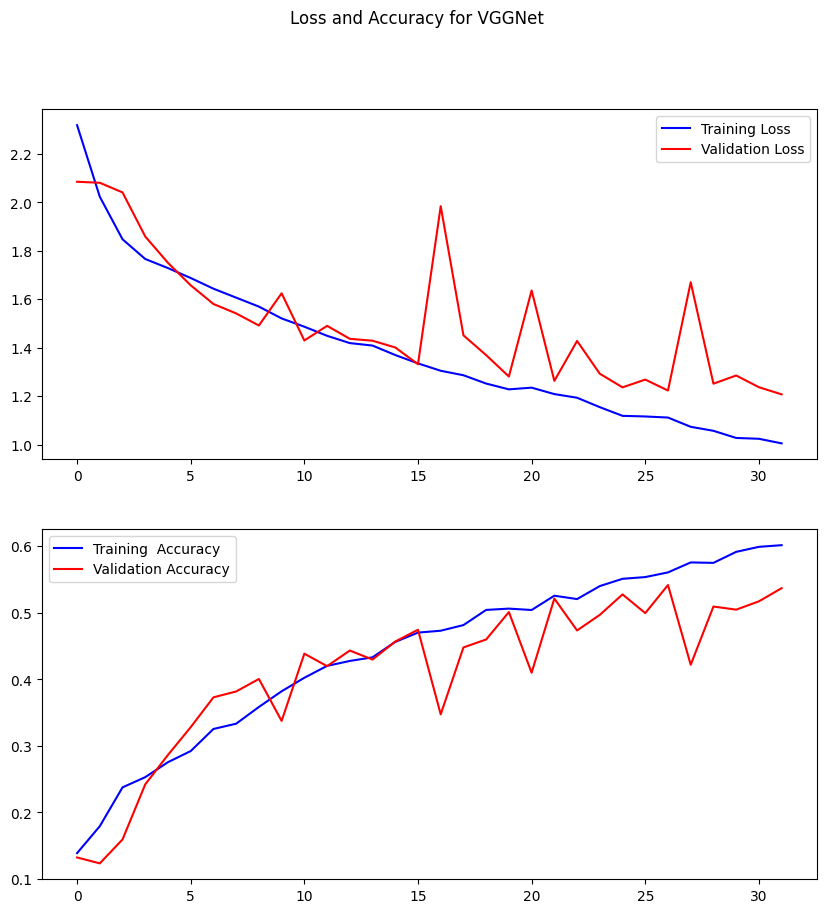

In [9]:
VGGNet.history.history.keys()
fig, ax = plt.subplots(2,1,figsize=(10,10))
fig.suptitle('Loss and Accuracy for VGGNet')

ax[0].plot(VGGNet.history.history['loss'], color='b', label='Training Loss')
ax[0].plot(VGGNet.history.history['val_loss'], color='r', label='Validation Loss')
ax[0].legend()

ax[1].plot(VGGNet.history.history['accuracy'], color='b', label='Training  Accuracy')
ax[1].plot(VGGNet.history.history['val_accuracy'], color='r', label='Validation Accuracy')
ax[1].legend()

plt.show()

In [10]:
y_pred_prob = tf.nn.softmax(VGGNet.predict(x_test))
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print("Total VGGNet accuracy:", accuracy)

60/60 [==============================] - 1s 9ms/step
Total VGGNet accuracy: 0.5375


In [11]:
VGGNetTuned = keras.models.clone_model(VGGNet)
VGGNetTuned.set_weights(VGGNet.get_weights())

for i in range(len(VGGNetTuned.layers)-5):
    VGGNetTuned.layers[i].trainable = False
for i in range(len(VGGNetTuned.layers)-5, len(VGGNetTuned.layers)):
    VGGNetTuned.layers[i].trainable = True

In [12]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8
)

VGGNetTuned.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=['accuracy']
)

VGGNetTuned.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 128, 128, 16)      0

In [13]:
VGGNetTuned.fit(
    x=x_tune,
    y=y_tune,
    validation_data=(x_test, y_test),
    batch_size=16,
    epochs=24,
    shuffle=True
)

Epoch 1/24
100/100 [==============================] - 2s 17ms/step - loss: 1.7980 - accuracy: 0.3469 - val_loss: 1.2712 - val_accuracy: 0.5469
Epoch 2/24
100/100 [==============================] - 1s 13ms/step - loss: 1.6553 - accuracy: 0.3681 - val_loss: 1.3678 - val_accuracy: 0.4875
Epoch 3/24
100/100 [==============================] - 1s 13ms/step - loss: 1.6326 - accuracy: 0.3800 - val_loss: 1.3745 - val_accuracy: 0.5000
Epoch 4/24
100/100 [==============================] - 1s 13ms/step - loss: 1.6087 - accuracy: 0.3781 - val_loss: 1.4104 - val_accuracy: 0.5021
Epoch 5/24
100/100 [==============================] - 1s 13ms/step - loss: 1.5958 - accuracy: 0.3913 - val_loss: 1.4345 - val_accuracy: 0.4917
Epoch 6/24
100/100 [==============================] - 1s 13ms/step - loss: 1.5502 - accuracy: 0.3944 - val_loss: 1.4659 - val_accuracy: 0.4792
Epoch 7/24
100/100 [==============================] - 1s 14ms/step - loss: 1.5603 - accuracy: 0.4006 - val_loss: 1.3938 - val_accuracy: 0.5089

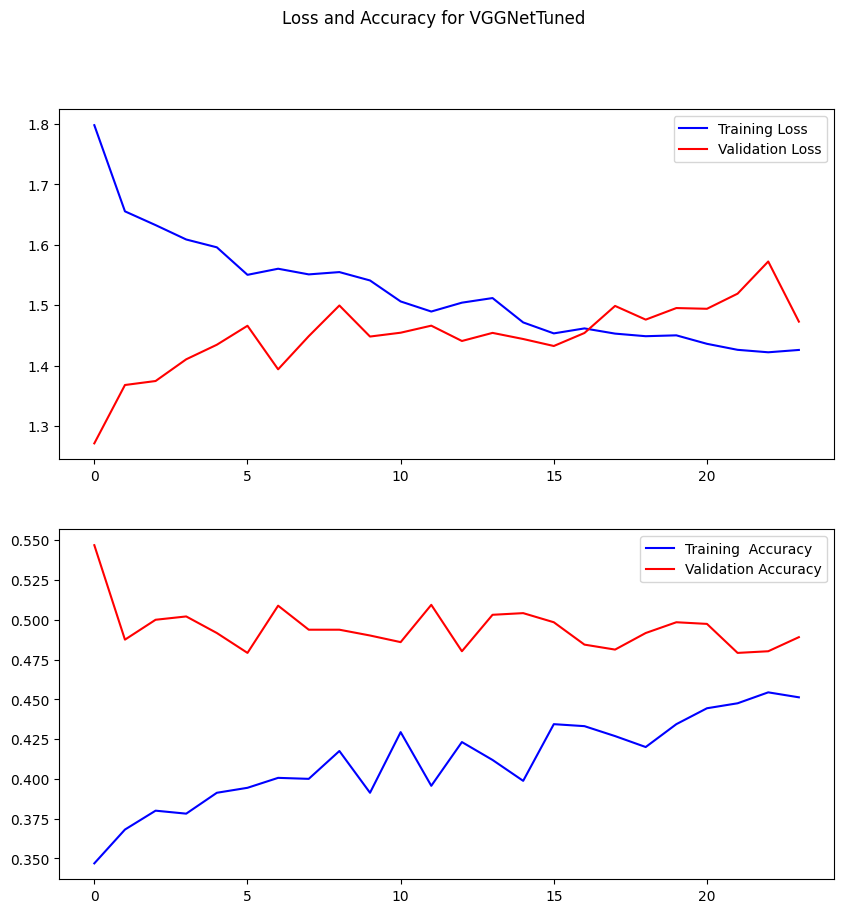

In [14]:
VGGNetTuned.history.history.keys()
fig, ax = plt.subplots(2,1,figsize=(10,10))
fig.suptitle('Loss and Accuracy for VGGNetTuned')

ax[0].plot(VGGNetTuned.history.history['loss'], color='b', label='Training Loss')
ax[0].plot(VGGNetTuned.history.history['val_loss'], color='r', label='Validation Loss')
ax[0].legend()

ax[1].plot(VGGNetTuned.history.history['accuracy'], color='b', label='Training  Accuracy')
ax[1].plot(VGGNetTuned.history.history['val_accuracy'], color='r', label='Validation Accuracy')
ax[1].legend()

plt.show()

In [15]:
y_tune_pred_prob = tf.nn.softmax(VGGNetTuned.predict(x_test))
y_tune_pred = np.argmax(y_tune_pred_prob, axis=1)

accuracy_tune = accuracy_score(y_test, y_tune_pred)
print("Total AlexNetTuned accuracy:", accuracy_tune)

60/60 [==============================] - 1s 9ms/step
Total AlexNetTuned accuracy: 0.4890625


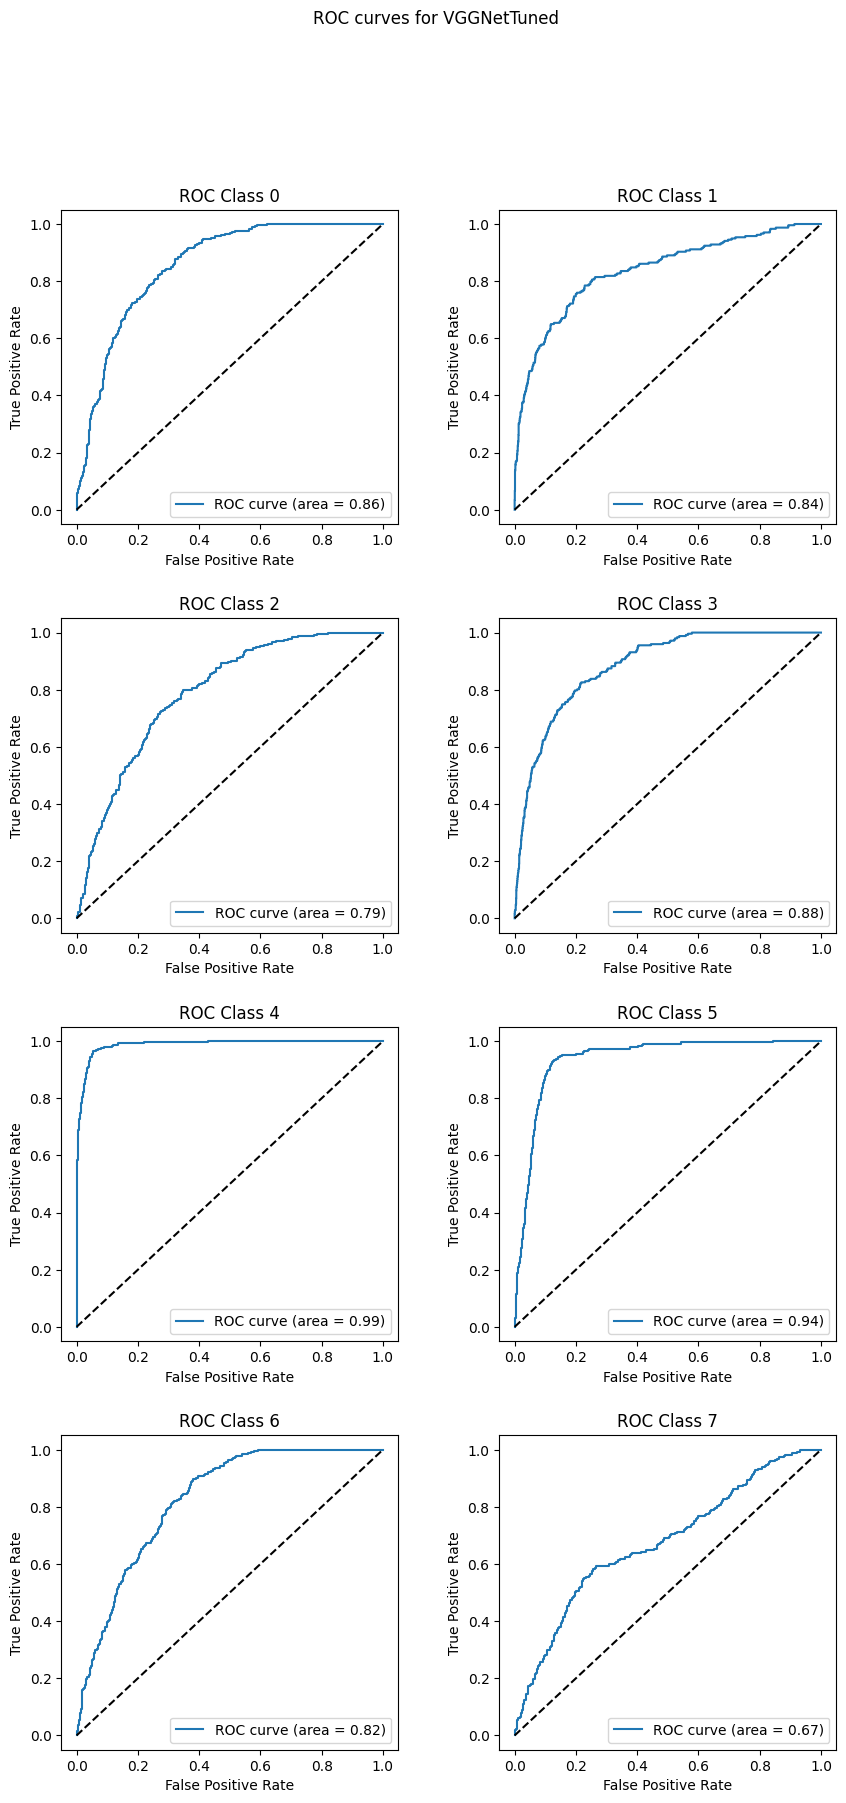

In [16]:
fig, axs = plt.subplots(4,2)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.set_size_inches(10, 20)
fig.suptitle('ROC curves for VGGNetTuned')

for i in range(8):

    y_test_class = np.zeros(y_test.shape)
    y_test_class[y_test==i] = 1
    
    y_tune_pred_prob_class = y_tune_pred_prob[:, i]

    fpr, tpr, thresholds = roc_curve(y_test_class, y_tune_pred_prob_class, pos_label=1)
    roc_auc = auc(fpr, tpr)

    j = i%2
    axs[i//2][j].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    axs[i//2][j].plot([0, 1], [0, 1], 'k--')

    axs[i//2][j].set_xlabel('False Positive Rate')
    axs[i//2][j].set_ylabel('True Positive Rate')
    axs[i//2][j].set_title(f'ROC Class {i}')
    axs[i//2][j].legend(loc="lower right")


In [17]:
for i in range(8):
    y_test_class = np.zeros(y_test.shape)
    y_test_class[y_test==i] = 1

    y_tune_pred_class = np.zeros(y_tune_pred.shape)
    y_tune_pred_class[y_tune_pred==i] = 1

    precision = precision_score(y_test_class, y_tune_pred_class)
    recall = recall_score(y_test_class, y_tune_pred_class)
    f1 = f1_score(y_test_class, y_tune_pred_class)

    print(f"Precision for class {i}: {round(precision, 3)}")
    print(f"Recall for class {i}: {round(recall, 3)}")
    print(f"F1-score for class {i}: {round(f1, 3)}\n")

Precision for class 0: 0.413
Recall for class 0: 0.328
F1-score for class 0: 0.366

Precision for class 1: 0.593
Recall for class 1: 0.43
F1-score for class 1: 0.499

Precision for class 2: 0.343
Recall for class 2: 0.338
F1-score for class 2: 0.341

Precision for class 3: 0.558
Recall for class 3: 0.47
F1-score for class 3: 0.51

Precision for class 4: 0.79
Recall for class 4: 0.933
F1-score for class 4: 0.856

Precision for class 5: 0.495
Recall for class 5: 0.807
F1-score for class 5: 0.613

Precision for class 6: 0.337
Recall for class 6: 0.388
F1-score for class 6: 0.36

Precision for class 7: 0.28
Recall for class 7: 0.198
F1-score for class 7: 0.232



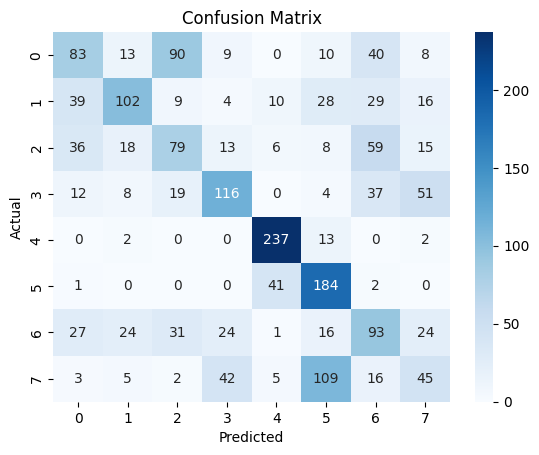

In [18]:
cm = confusion_matrix(y_test, y_tune_pred)

labels = np.unique(y_test)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)

plt.title('Confusion matrix for VGGNetTuned')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)
plt.yticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)

plt.show()